# Difftest Results

Connect to results database:

In [1]:
import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen", "CLgen w. cl_launcher", "CLgen w. co"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult, cl_launcherCLgenResult, coCLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES]),
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen,CLgen w. cl_launcher,CLgen w. co
#. Programs,10001,10001,9238,5930,2385,3385
#. Testbeds,8,5,5,7,7,7
#. Params,4,4,4,4,4,4
#. Results,247808,200020,193477,122798,66780,53840


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

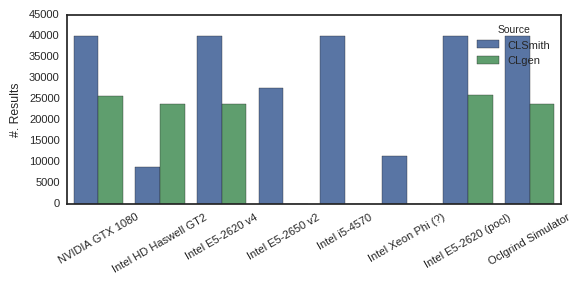

In [19]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

def get_testbed_info(config_id, testbed_id, source, results_table):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    num_results = session.query(results_table).filter(results_table.testbed_id == testbed_id).count()
    return {
        "Device": device_str(testbed.device),
        "#. Results": num_results,
        "Source": source,
    }

data = []
for source, table in [("CLSmith", CLSmithResult), ("CLgen", CLgenResult)]:
    data += [get_testbed_info(*x, source, table) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="#. Results", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("#. Results")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
viz.finalise(figsize=(6, 3))

/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


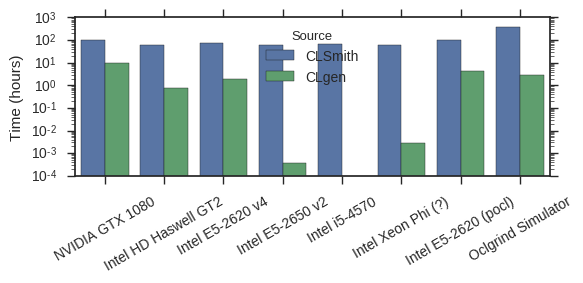

In [75]:
def get_testbed_info(config_id, testbed_id, source, results_table, program_table, reduction_table, harness_table=None):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    total_time = session.query(sql.sql.func.sum(results_table.runtime))\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
    total_time += session.query(sql.sql.func.sum(reduction_table.runtime))\
        .join(results_table)\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
#     if harness_table:
#         total_time += session.query(sql.sql.func.sum(harness_table.generation_time)).filter(Testbed.id == testbed_id).first()[0] or 0
    return {
        "Device": device_str(testbed.device),
        "Test Time": total_time / 3600,
        "Source": source,
    }

data = []
for row in [("CLSmith", CLSmithResult, CLSmithProgram, CLSmithReduction), 
                       ("CLgen", CLgenResult, CLgenProgram, CLgenReduction, CLgenHarness)]:
    data += [get_testbed_info(*x, *row) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="Test Time", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("Time (hours)")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
ax.set_yscale("log", nonposy='clip')
viz.finalise(figsize=(6, 3))

In [20]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict

def get_total_submitted(testbed: Testbed):
    submitable_results = [coCLgenResult, cl_launcherCLgenResult]
    
    def get_submitted(table):
        return session.query(table).filter(table.testbed_id == testbed.id, table.submitted).count()

    def get_generated(table):
        return session.query(table).filter(table.testbed_id == testbed.id, sql.or_(table.submitted, table.dupe)).count()
    
    return (
        sum(get_generated(table) for table in submitable_results), 
        sum(get_submitted(table) for table in submitable_results)
    )


def get_row(config_id, testbed_id):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Device"] = testbed.device
    d["Platform"] = platform_str(testbed.platform)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    d["B.R. Generated"], d["B.R. Submitted"] = get_total_submitted(testbed)
    return d

table = pd.DataFrame([get_row(*x) for x in CONFIGURATIONS])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile, index=None)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,#.,Device,Platform,Driver,OpenCL,Operating system,Device type,B.R. Generated,B.R. Submitted
0,1,GeForce GTX 1080,NVIDIA CUDA,375.39,1.2,Ubuntu 16.04 64bit,GPU,13,7
1,2,Intel(R) HD Graphics Haswell GT2 Desktop,Intel Gen OCL Driver,1.3,1.2,Ubuntu 16.04 64bit,GPU,35,11
2,3,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,Intel OpenCL,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,10,5
3,4,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,Intel OpenCL,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,2,1
4,5,Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz,Intel OpenCL,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,4,4
5,6,Intel(R) Many Integrated Core Acceleration Card,Intel OpenCL,1.2,1.2,CentOS 7.1 64bit,Accelerator,0,0
6,7,pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,POCL,0.14,2.0,Ubuntu 16.04 64bit,CPU,170,52
7,8,Oclgrind Simulator,Oclgrind,16.10,1.2,Ubuntu 16.04 64bit,Emulator,0,0


In [21]:
%run mkmegatable.ipy

insufficient CLgenResults for GeForce GTX 1080 False
insufficient CLgenResults for GeForce GTX 1080 True
insufficient CLSmithResults for Intel(R) HD Graphics Haswell GT2 Desktop False
insufficient CLgenResults for Intel(R) HD Graphics Haswell GT2 Desktop False
insufficient CLSmithResults for Intel(R) HD Graphics Haswell GT2 Desktop True
insufficient CLgenResults for Intel(R) HD Graphics Haswell GT2 Desktop True
insufficient CLgenResults for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz False
insufficient CLgenResults for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz True
insufficient CLSmithResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz False
insufficient CLgenResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz False
insufficient CLSmithResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz True
insufficient CLgenResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz True
insufficient CLgenResults for Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz False
insufficient CLS

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


## Runtimes

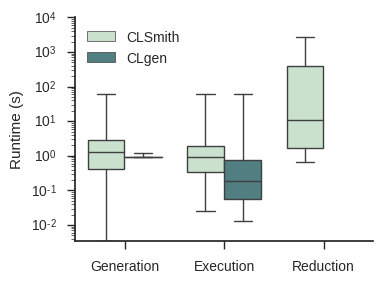

In [61]:
sns.set(style="ticks")

def plot_runtimes(*args, **kwargs):
    TIMEOUT = 60
    
    # CLSmith times
    q = session.query(
            CLSmithResult.runtime, 
            CLSmithProgram.runtime, 
            sql.sql.func.ifnull(CLSmithReduction.runtime, 0))\
        .outerjoin(CLSmithProgram)\
        .outerjoin(CLSmithReduction)\
        .filter(CLSmithResult.classification != None)
    clsmith_times = np.array([row for row in q])
    
    # CLgen times
    q = session.query(
            CLgenResult.runtime,
            sql.sql.func.ifnull(CLgenProgram.runtime, clgen_generation_time) + CLgenHarness.generation_time,
            sql.sql.func.ifnull(CLgenReduction.runtime, 0))\
        .outerjoin(CLgenProgram)\
        .outerjoin(CLgenHarness)\
        .outerjoin(CLgenReduction)\
        .filter(CLgenResult.classification != None)
    clgen_times = np.array([row for row in q])

    table = (
        [("Execution", x, "CLSmith") for x in clsmith_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLSmith") for x in clsmith_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLSmith") for x in clsmith_times[:,2] if x > 0] +
        [("Execution", x, "CLgen") for x in clgen_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLgen") for x in clgen_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLgen") for x in clgen_times[:,2] if x > 0])
    table = pd.DataFrame(table, columns=["Name", "Runtime (s)", "Source"])

    # Plot
    palette = sns.cubehelix_palette(2, rot=-.4, light=.85, dark=.45)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
       # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(figsize=(4, 3))

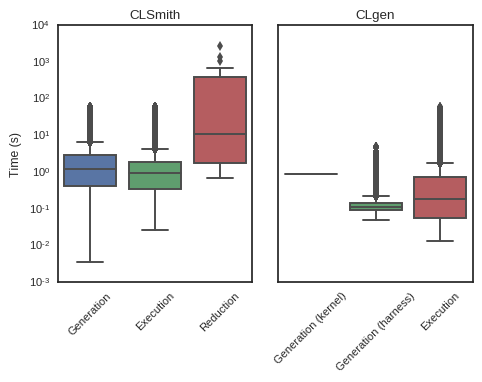

In [22]:
def boxplot(ax, data, labels):
    sns.boxplot(data=data, ax=ax)
    # ax.boxplot(data)
    ax.set_xticklabels(labels)
    ax.set_yscale("log", nonposy='clip')
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks

def plot_clsmith_runtimes(ax):
    # Tables:
    results_table = CLSmithResult
    programs_table = CLSmithProgram
    reductions_table = CLSmithReduction
    
    # Runtimes:
    generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
    runtime = results_table.runtime
    reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)

    # Go fetch!
    q = session.query(runtime, generation_time, reduction_time)\
        .outerjoin(programs_table)\
        .outerjoin(reductions_table)\
        .filter(results_table.classification != None)\
        .order_by(results_table.date)
    
    # Format data
    times = np.array([row for row in q])
    runtimes = np.array([x for x in times[:,0] if x < 60])
    generation_times = np.array([x for x in times[:,1] if x < 60])
    reduction_times = np.array([x for x in times[:,2] if x > 0])
    
    # Plot
    boxplot(ax, 
            [generation_times, runtimes, reduction_times],
            ['Generation', 'Execution', 'Reduction'])

def plot_clgen_runtimes(ax):
    # Tables:
    results_table = CLgenResult
    programs_table = CLgenProgram
    harness_table = CLgenHarness
    reductions_table = CLgenReduction
    
    # Runtimes:
    generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
    harness_time = harness_table.generation_time + harness_table.compile_time
    runtime = results_table.runtime
    reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)

    # Go fetch!
    q = session.query(runtime, generation_time, harness_time, reduction_time)\
        .outerjoin(programs_table)\
        .outerjoin(harness_table)\
        .outerjoin(reductions_table)\
        .filter(results_table.classification != None)\
        .order_by(results_table.date)
    
    # Format data
    times = np.array([row for row in q])
    runtimes = np.array([x for x in times[:,0] if x < 60])
    generation_times = np.array([x for x in times[:,1] if x < 60])
    harness_times = np.array([x for x in times[:,2] if x < 60])
    
    # Plot
    boxplot(ax, 
            [generation_times, harness_times, runtimes],
            ['Generation (kernel)', 'Generation (harness)', 'Execution'])


def plot_runtimes(*args, **kwargs):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    plot_clsmith_runtimes(ax1)
    ax1.set_title("CLSmith")
    ax1.set_ylabel("Time (s)")

    plot_clgen_runtimes(ax2)
    ax2.set_title("CLgen")
    viz.finalise(*args, **kwargs)


plot_runtimes(figsize=(5, 4))

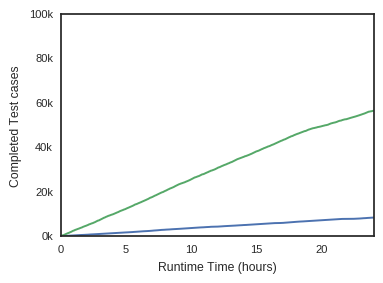

In [7]:
from matplotlib.ticker import FuncFormatter

def plot_totaltime(ax, results_table, programs_table, reductions_table):
    generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
    runtime = results_table.runtime
    reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
    total_time = generation_time + runtime + reduction_time

    q = session.query(total_time)\
        .outerjoin(programs_table)\
        .outerjoin(reductions_table)\
        .filter(results_table.classification != None)\
        .order_by(results_table.date)

    times = np.array([row[0] / 3600 for row in q]).cumsum()
    ax.plot(times, range(len(times)))
    ax.set_xlim((0, 24))
    ax.set_ylim((0, 100000))

def thousands(x, pos):
    return "{:.0f}k".format(x / 1000)

formatter = FuncFormatter(thousands)
    
ax = plt.gca()
plot_totaltime(ax, CLSmithResult, CLSmithProgram, CLSmithReduction)
plot_totaltime(ax, CLgenResult, CLgenProgram, CLgenReduction)

ax.set_xlabel("Runtime Time (hours)")
ax.set_ylabel("Completed Test cases")
ax.yaxis.set_major_formatter(formatter)
viz.finalise(figsize=(4, 3))

## Runtime Parameters

### cl_launcher

In [8]:
# CL_LAUNCHER_TABLE_NAMES = ["CLSmith", "CLgen w. cl_launcher"]
# CL_LAUNCHER_TABLES = [CLSmithResult, cl_launcherCLgenResult]

# q = session.query(cl_launcherParams).order_by(
#         cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
#         cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
#         cl_launcherParams.optimizations)

# data = []
# for param in q:
#     nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
#     data.append((
#         param.id, [param.gsize, param.lsize, param.optimizations_on_off ] + [
#             session.query(t).filter(t.params == param).count()
#             for t in CL_LAUNCHER_TABLES
#         ]))
# i, d = zip(*data)

# cl_launcher_params = pd.DataFrame(list(d), index=i, columns=[
#     "Global size", "Local size", "Optimizations"] + [
#         f"#. {t}" for t in CL_LAUNCHER_TABLE_NAMES])
# cl_launcher_params

### cldrive

In [9]:
# CLDRIVE_TABLE_NAMES = ["CLSmith w. cldrive", "GitHub", "CLgen"]
# CLDRIVE_TABLES = [cldriveCLSmithResult, GitHubResult, CLgenResult]

# q = session.query(cldriveParams).order_by(
#         cldriveParams.size,
#         cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
#         cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
#         cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations)

# # push LaTex to Overleaf
# !cd ~/docs/paper-project_b/ && git pull --rebase
# data = []
# for param in q:
#     data.append([param.size, param.gsize, param.lsize, param.optimizations_on_off])
# table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
#     "Dataset Size", "Global size", "Workgroup size", "Optimizations"])
# with open(os.path.expanduser("~/docs/paper-project_b/build/tab/cldrive-params.tex"), "w") as outfile:
#     table.to_latex(buf=outfile)
# !cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/cldrive-params.tex" && git push
# table

# Experimental Results

## Runtimes

Excluding runs which terminated in non-zero status:

In [10]:
# import numpy as np

# runtimes = [np.array(session.query(table.runtime).filter(table.status == 0).all()) for table in TABLES]
# data = [
#     ("Min", [r.min() for r in runtimes]),
#     ("Median", [np.median(r) for r in runtimes]),
#     ("Mean", [r.mean() for r in runtimes]),
#     ("Max", [r.max() for r in runtimes])
# ]
# i, d = zip(*data)
# runtimes = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
# runtimes

## Outcomes & Classifications

**Pandas tables of outcomes**

In [11]:
# outcomes = {}

# for name, table in zip(CL_LAUNCHER_TABLE_NAMES + CLDRIVE_TABLE_NAMES, CL_LAUNCHER_TABLES + CLDRIVE_TABLES):
#     r = []
#     for testbed in session.query(Testbed).all():
#         nresult = session.query(table).filter(table.testbed == testbed).count()

#         q = session.query(table.outcome, sql.func.count(table.outcome)).filter(
#             table.testbed == testbed).group_by(table.outcome).order_by(
#                 sql.desc(sql.func.count(table.outcome)))

#         for outcome, count in q.all():
#             ratio = (count / nresult) * 100
#             r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
#     outcomes[name] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])

# print("done.")

**Pandas tables of classifications**

In [12]:
# classifications = {}

# classificationsSort = [
#     'Invalid testcase',
#     'Build failure',
#     'Runtime crash',
#     'No majority',
#     'Wrong code',
#     'Okay'
# ]

# def escape(val):
#     if val is None:
#         return val
#     else:
#         return str(classificationsSort.index(val)) + ". " + val

# for name, table in zip(CL_LAUNCHER_TABLE_NAMES + CLDRIVE_TABLE_NAMES, CL_LAUNCHER_TABLES + CLDRIVE_TABLES):
#     r = []
#     for testbed in session.query(Testbed).all():
#         nresult = session.query(table).filter(table.testbed == testbed).count()

#         q = session.query(table.classification, sql.func.count(table.classification)).filter(
#             table.testbed == testbed).group_by(table.classification).order_by(
#                 sql.desc(sql.func.count(table.classification)))

#         for val, count in q.all():
#             ratio = (count / nresult) * 100
#             r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
#     classifications[name] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])

# print("done.")

In [13]:
# classifications["CLgen w. cl_launcher"]

## Experimental Results

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from labm8 import viz
# %matplotlib inline

# def plot_outcomes(table, name, dictname=outcomes, key='Outcome'):
#     ax = dictname[name].pivot('Device', key)['Count'].plot(
#         kind='bar', stacked=True, colormap="Reds_r", sort_columns=True)

#     nprog = session.query(table.program_id).group_by(table.program_id).count()
#     nparam = session.query(table.params_id).group_by(table.params_id).count()
#     plt.title(f"{nprog} {name} x {nparam} parameters")
#     plt.ylabel("Results")
#     plt.xlabel("")

#     plt.ylim(0, nprog * nparam)

#     # reverse legend order (because plot stacks from bottom to top, and legend goes from top to bottom)
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

#     viz.finalise(figsize=(3.5, 8))
    
    
# def summarize(table_name):
#     """ summarize a table of classifications """
#     table = classifications[table_name]

#     def get_val(classification):
#         try:
#             return table.loc[
#                 (table['Device'] == device) & (table['Classification'] == classification)]['Count'].values[0]
#         except IndexError:
#             return 0
    
#     columns = ['Platform', 'Device', 'Driver', 'Invalid Testcases', 'Build Failures', 'Runtime Crashes', 'Incorrect Outputs', 'Okay']
#     devices = sorted(set(table['Device'].values))

#     d = []    
#     for device in devices:
#         lookup = dict((v, k) for k, v in DEVICES.items())
#         full_name = lookup.get(device, device)
        
#         # lookup the testbed
#         q = session.query(Testbed).filter(Testbed.device == full_name).all()
#         if len(q) != 1:
#             raise q
#         testbed = q[0]
        
#         r = [
#             PLATFORMS.get(testbed.platform, testbed.platform),
#             device,
#             DRIVERS.get(testbed.driver, testbed.driver),
#             get_val('0. Invalid testcase'),
#             get_val('1. Build failure'),
#             get_val('2. Runtime crash'),
#             get_val('3. Wrong code'),
#             get_val('4. Okay'),
#         ]
#         d.append(r)
#     summary = pd.DataFrame(d, columns=columns, index=range(1, len(devices)+1))

#     !cd ~/docs/paper-project_b/ && git pull --rebase >/dev/null
#     name = '-'.join(table_name.split())
#     with open(os.path.expanduser(f"~/docs/paper-project_b/build/tab/results-{name}.tex"), "w") as outfile:
#         summary.to_latex(buf=outfile)
#     !cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: summarize table" >/dev/null && git push >/dev/null
#     return summary